# Model Exploration

## 1. Approach
### 1.1 Thoughts

We will predict **the realized volatility of the next ten-minutes time window** with two data sets of the last ten minutes (600 seconds). One dataset contains ask and bid prices of almost each second, which allows us to calculate the realized volatility of the last ten minutes. The other dataset contains the actual record of stock trading, which is more sparse.

Please look at this notebook for the detailed explanation: https://www.kaggle.com/jiashenliu/introduction-to-financial-concepts-and-data


### 1.2 Feature Engineering

Here are my thoughts on feature engieering with my background knowledge on financial market. 

 - price_spread: the difference between ask price and bid price. Wide spread means low liquidity, leading to high volatility.
 - volume: the sum of the ask/bid size. Low volume means low liquidity, leading to high volatility
 - volume_imbalance: the difference between ask size and bid size. Large imbalance means low liquidity for one side, leading to high volatility
 - wap: weighted averaged price considers both the level and size of order. If bid size is large, price leans upward. The change in wap is the definition of volatility. Perhaps, with autocorrelation, high wap lead to high volatility.
 
Also, I created features only using last XX seconds to capture the dynamics of volatility further. Trade data can reflect that liquidity ties to volatility.


### 1.3 Model Building
- optimize the weight for RMSPE: see this discussion https://www.kaggle.com/c/optiver-realized-volatility-prediction/discussion/250324
    - !!! Let's look at this more later

- For the baseline, one model for all stocks: model by stock_id does not work well. I am afraid of overfitting as well. stock_id is used as categorical and for target mean encoding.
    - !!! Each stock do give different volatility. Another approach is to use clustering to have different model / parameter for different groups of stocks. This can cause potential overfitting, so need to be careful on the levels of the tree.

## 2. Preparation

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import glob

In [110]:
# data directory
data_dir = '../input/'

### 2.1 Functions for preprocess

In [111]:
def calc_wap(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1'])/(df['bid_size1'] + df['ask_size1'])
    return wap
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2'])/(df['bid_size2'] + df['ask_size2'])
    return wap

In [112]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

In [113]:
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

In [114]:
def count_unique(series):
    return len(np.unique(series))

In [115]:
book_train = pd.read_parquet(data_dir + "book_train.parquet/stock_id=15")
book_train.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,0.999519,0.999839,0.999454,0.999904,2,166,2,12
1,5,1,0.999711,1.000225,0.999647,1.000289,100,20,100,20
2,5,2,0.999775,1.000225,0.999711,1.000289,1,20,400,20
3,5,3,0.999839,1.000225,0.999775,1.000289,100,20,1,20
4,5,4,0.999839,1.000225,0.999711,1.000289,1,20,400,20


### 2.2 Main function for preprocessing book data

In [116]:
def preprocessor_book(file_path):
    df = pd.read_parquet(file_path)
    #calculate return etc
    df['wap'] = calc_wap(df)
    df['log_return'] = df.groupby('time_id')['wap'].transform(log_return)
    
    df['wap2'] = calc_wap2(df)
    df['log_return2'] = df.groupby('time_id')['wap2'].transform(log_return)

    df['wap_balance'] = abs(df['wap'] - df['wap2'])
    
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1'])/2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

    #dict for aggregate
    create_feature_dict = {
        'log_return':[realized_volatility],
        'log_return2':[realized_volatility],
        'wap_balance':[np.mean],
        'price_spread':[np.mean],
        'bid_spread':[np.mean],
        'ask_spread':[np.mean],
        'volume_imbalance':[np.mean],
        'total_volume':[np.mean],
        'wap':[np.mean],
            }

    #####groupby / all seconds
    df_feature = pd.DataFrame(df.groupby(['time_id']).agg(create_feature_dict)).reset_index()
    
    df_feature.columns = ['_'.join(col) for col in df_feature.columns] #time_id is changed to time_id_
        
    ######groupby / last XX seconds
    last_seconds = [300]
    
    for second in last_seconds:
        second = 600 - second 
    
        df_feature_sec = pd.DataFrame(df.query(f'seconds_in_bucket >= {second}').groupby(['time_id']).agg(create_feature_dict)).reset_index()

        df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns] #time_id is changed to time_id_
     
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))

        df_feature = pd.merge(df_feature,df_feature_sec,how='left',left_on='time_id_',right_on=f'time_id__{second}')
        df_feature = df_feature.drop([f'time_id__{second}'],axis=1)
    
    #create row_id
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].transform(lambda x:f'{stock_id}-{x}')
    df_feature = df_feature.drop(['time_id_'],axis=1)
    
    return df_feature

In [117]:
%%time
file_path = data_dir + "book_train.parquet/stock_id=0"
preprocessor_book(file_path)

/var/folders/x2/ljb2p1456lj2hps84wzsz7vh0000gn/T/ipykernel_5718/2387059575.py:32: FutureWarning: The provided callable <function mean at 0x11d81cf40> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_feature = pd.DataFrame(df.groupby(['time_id']).agg(create_feature_dict)).reset_index()


CPU times: user 794 ms, sys: 81.7 ms, total: 876 ms
Wall time: 935 ms


/var/folders/x2/ljb2p1456lj2hps84wzsz7vh0000gn/T/ipykernel_5718/2387059575.py:42: FutureWarning: The provided callable <function mean at 0x11d81cf40> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_feature_sec = pd.DataFrame(df.query(f'seconds_in_bucket >= {second}').groupby(['time_id']).agg(create_feature_dict)).reset_index()


,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_mean_300,price_spread_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,total_volume_mean_300,wap_mean_300,row_id
0,0.004499,0.006999,0.000388,0.000852,0.000176,-0.000151,134.894040,323.496689,1.003725,0.002953,0.004863,0.000372,0.000822,0.000223,-0.000162,137.158273,294.928058,1.003753,0-5
1,0.001204,0.002476,0.000212,0.000394,0.000142,-0.000135,142.050000,411.450000,1.000239,0.000981,0.002009,0.000239,0.000353,0.000164,-0.000123,135.513043,484.521739,1.000397,0-11
2,0.002369,0.004801,0.000331,0.000725,0.000197,-0.000198,141.414894,416.351064,0.999542,0.001295,0.003196,0.000431,0.000689,0.000141,-0.000249,144.147059,455.235294,0.998685,0-16
3,0.002574,0.003637,0.000380,0.000860,0.000190,-0.000108,146.216667,435.266667,0.998832,0.001776,0.002713,0.000331,0.000833,0.000158,-0.000095,144.698113,418.169811,0.998436,0-31
4,0.001894,0.003257,0.000254,0.000397,0.000191,-0.000109,123.846591,343.221591,0.999619,0.001520,0.002188,0.000252,0.000425,0.000191,-0.000120,99.449438,407.584270,0.999488,0-62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,0.002579,0.003821,0.000212,0.000552,0.000083,-0.000182,197.144781,374.235690,0.997938,0.001673,0.002573,0.000193,0.000509,0.000062,-0.000169,233.946667,350.560000,0.997519,0-32751
3826,0.002206,0.002847,0.000267,0.000542,0.000092,-0.000172,233.781553,621.131068,1.000310,0.001487,0.002255,0.000300,0.000588,0.000074,-0.000177,257.920000,668.640000,1.000682,0-32753
3827,0.002913,0.003266,0.000237,0.000525,0.000202,-0.000083,115.829787,343.734043,0.999552,0.001929,0.002646,0.000216,0.000446,0.000191,-0.000075,105.432692,326.759615,1.000111,0-32758
3828,0.003046,0.005105,0.000245,0.000480,0.000113,-0.000166,132.074919,385.429967,1.002357,0.002137,0.003934,0.000269,0.000516,0.000096,-0.000175,123.423313,394.588957,1.002277,0-32763


In [118]:
trade_train = pd.read_parquet(data_dir + "trade_train.parquet/stock_id=0")
trade_train.head(15)

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1
5,5,78,1.003762,134,5
6,5,122,1.004207,102,3
7,5,127,1.004577,1,1
8,5,144,1.004370,6,1
9,5,147,1.003964,233,4


### 2.3 Main function for preprocessing trade data

In [119]:
def preprocessor_trade(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].transform(log_return)
    
    
    aggregate_dictionary = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.mean],
    }
    
    df_feature = df.groupby('time_id').agg(aggregate_dictionary)
    
    df_feature = df_feature.reset_index()
    df_feature.columns = ['_'.join(col) for col in df_feature.columns]

    
    ######groupby / last XX seconds
    last_seconds = [300]
    
    for second in last_seconds:
        second = 600 - second
    
        df_feature_sec = df.query(f'seconds_in_bucket >= {second}').groupby('time_id').agg(aggregate_dictionary)
        df_feature_sec = df_feature_sec.reset_index()
        
        df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))
        
        df_feature = pd.merge(df_feature,df_feature_sec,how='left',left_on='time_id_',right_on=f'time_id__{second}')
        df_feature = df_feature.drop([f'time_id__{second}'],axis=1)
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].transform(lambda x:f'{stock_id}-{x}')
    df_feature = df_feature.drop(['trade_time_id_'],axis=1)
    
    return df_feature

In [120]:
%%time
file_path = data_dir + "trade_train.parquet/stock_id=0"
preprocessor_trade(file_path)

CPU times: user 376 ms, sys: 13.4 ms, total: 390 ms
Wall time: 386 ms


/var/folders/x2/ljb2p1456lj2hps84wzsz7vh0000gn/T/ipykernel_5718/2475913537.py:13: FutureWarning: The provided callable <function sum at 0x107ffbb00> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_feature = df.groupby('time_id').agg(aggregate_dictionary)
/var/folders/x2/ljb2p1456lj2hps84wzsz7vh0000gn/T/ipykernel_5718/2475913537.py:13: FutureWarning: The provided callable <function mean at 0x11d81cf40> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_feature = df.groupby('time_id').agg(aggregate_dictionary)
/var/folders/x2/ljb2p1456lj2hps84wzsz7vh0000gn/T/ipykernel_5718/2475913537.py:25: FutureWarning: The provided callable <function sum at 0x107ffbb00> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided ca

,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,row_id
0,0.002006,40,3179,2.750000,0.001308,21.0,1587.0,2.571429,0-5
1,0.000901,30,1289,1.900000,0.000587,16.0,900.0,2.250000,0-11
2,0.001961,25,2161,2.720000,0.001137,12.0,1189.0,3.166667,0-16
3,0.001561,15,1962,3.933333,0.001089,9.0,1556.0,5.111111,0-31
4,0.000871,22,1791,4.045455,0.000453,11.0,1219.0,4.909091,0-62
...,...,...,...,...,...,...,...,...,...
3825,0.001519,52,3450,3.057692,0.001162,35.0,2365.0,3.257143,0-32751
3826,0.001411,28,4547,3.892857,0.001066,12.0,2161.0,4.250000,0-32753
3827,0.001521,36,4250,3.500000,0.001242,22.0,2294.0,3.727273,0-32758
3828,0.001794,53,3217,2.150943,0.001404,25.0,1627.0,1.920000,0-32763


### 2.4 Combined preprocessor function

In [121]:
def preprocessor(list_stock_ids, is_train = True):
    from joblib import Parallel, delayed # parallel computing to save time
    df = pd.DataFrame()
    
    def for_joblib(stock_id):
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
            
        df_tmp = pd.merge(preprocessor_book(file_path_book),preprocessor_trade(file_path_trade),on='row_id',how='left')
     
        return pd.concat([df,df_tmp])
    
    df = Parallel(n_jobs=-1, verbose=1)(
        delayed(for_joblib)(stock_id) for stock_id in list_stock_ids
        )

    df =  pd.concat(df,ignore_index = True)
    return df


In [122]:
list_stock_ids = [0,1]
preprocessor(list_stock_ids, is_train = True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/var/folders/x2/ljb2p1456lj2hps84wzsz7vh0000gn/T/ipykernel_5718/2387059575.py:32: FutureWarning: The provided callable <function mean at 0x101b8f420> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
/var/folders/x2/ljb2p1456lj2hps84wzsz7vh0000gn/T/ipykernel_5718/2387059575.py:32: FutureWarning: The provided callable <function mean at 0x103aef420> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
/var/folders/x2/ljb2p1456lj2hps84wzsz7vh0000gn/T/ipykernel_5718/2387059575.py:42: FutureWarning: The provided callable <function mean at 0x101b8f420> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep curren

,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_300,...,wap_mean_300,row_id,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300
0,0.004499,0.006999,0.000388,0.000852,0.000176,-0.000151,134.894040,323.496689,1.003725,0.002953,...,1.003753,0-5,0.002006,40,3179,2.750000,0.001308,21.0,1587.0,2.571429
1,0.001204,0.002476,0.000212,0.000394,0.000142,-0.000135,142.050000,411.450000,1.000239,0.000981,...,1.000397,0-11,0.000901,30,1289,1.900000,0.000587,16.0,900.0,2.250000
2,0.002369,0.004801,0.000331,0.000725,0.000197,-0.000198,141.414894,416.351064,0.999542,0.001295,...,0.998685,0-16,0.001961,25,2161,2.720000,0.001137,12.0,1189.0,3.166667
3,0.002574,0.003637,0.000380,0.000860,0.000190,-0.000108,146.216667,435.266667,0.998832,0.001776,...,0.998436,0-31,0.001561,15,1962,3.933333,0.001089,9.0,1556.0,5.111111
4,0.001894,0.003257,0.000254,0.000397,0.000191,-0.000109,123.846591,343.221591,0.999619,0.001520,...,0.999488,0-62,0.000871,22,1791,4.045455,0.000453,11.0,1219.0,4.909091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7655,0.003723,0.004996,0.000330,0.000597,0.000157,-0.000118,125.013029,296.185668,1.000142,0.002212,...,1.000130,1-32751,0.001776,49,3249,2.775510,0.001280,23.0,1889.0,3.608696
7656,0.010829,0.012168,0.000403,0.000922,0.000159,-0.000125,254.006073,567.840081,1.007503,0.008499,...,1.012343,1-32753,0.008492,183,75903,7.874317,0.006310,88.0,30858.0,8.136364
7657,0.003135,0.004268,0.000243,0.000648,0.000141,-0.000132,163.645367,426.603834,1.000854,0.002108,...,1.001250,1-32758,0.001927,26,2239,2.615385,0.001567,11.0,980.0,2.727273
7658,0.003750,0.005773,0.000199,0.000421,0.000190,-0.000231,138.235023,526.317972,1.003032,0.002728,...,1.004296,1-32763,0.002856,109,16648,2.935780,0.001919,57.0,8274.0,2.701754


### 2.5 Training set

In [123]:
train = pd.read_csv(data_dir + 'train.csv')

In [124]:
train_ids = train.stock_id.unique()
train_ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  46,  47,  48,  50,  51,  52,  53,  55,  56,  58,
        59,  60,  61,  62,  63,  64,  66,  67,  68,  69,  70,  72,  73,
        74,  75,  76,  77,  78,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       118, 119, 120, 122, 123, 124, 125, 126])

In [125]:
%%time
df_train = preprocessor(list_stock_ids= train_ids, is_train = True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/var/folders/x2/ljb2p1456lj2hps84wzsz7vh0000gn/T/ipykernel_5718/2387059575.py:32: FutureWarning: The provided callable <function mean at 0x101b8f420> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
/var/folders/x2/ljb2p1456lj2hps84wzsz7vh0000gn/T/ipykernel_5718/2387059575.py:32: FutureWarning: The provided callable <function mean at 0x103aef420> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
/var/folders/x2/ljb2p1456lj2hps84wzsz7vh0000gn/T/ipykernel_5718/2387059575.py:32: FutureWarning: The provided callable <function mean at 0x103a13420> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep curren

CPU times: user 590 ms, sys: 498 ms, total: 1.09 s
Wall time: 39.1 s


/var/folders/x2/ljb2p1456lj2hps84wzsz7vh0000gn/T/ipykernel_5718/2475913537.py:25: FutureWarning: The provided callable <function sum at 0x100e5a020> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
/var/folders/x2/ljb2p1456lj2hps84wzsz7vh0000gn/T/ipykernel_5718/2475913537.py:25: FutureWarning: The provided callable <function mean at 0x100e5b420> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   39.0s finished


In [126]:
train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
train = train[['row_id','target']]
df_train = train.merge(df_train, on = ['row_id'], how = 'left')

In [127]:
df_train.head()

,row_id,target,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,...,total_volume_mean_300,wap_mean_300,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300
0,0-5,0.004136,0.004499,0.006999,0.000388,0.000852,0.000176,-0.000151,134.894040,323.496689,...,294.928058,1.003753,0.002006,40.0,3179.0,2.750000,0.001308,21.0,1587.0,2.571429
1,0-11,0.001445,0.001204,0.002476,0.000212,0.000394,0.000142,-0.000135,142.050000,411.450000,...,484.521739,1.000397,0.000901,30.0,1289.0,1.900000,0.000587,16.0,900.0,2.250000
2,0-16,0.002168,0.002369,0.004801,0.000331,0.000725,0.000197,-0.000198,141.414894,416.351064,...,455.235294,0.998685,0.001961,25.0,2161.0,2.720000,0.001137,12.0,1189.0,3.166667
3,0-31,0.002195,0.002574,0.003637,0.000380,0.000860,0.000190,-0.000108,146.216667,435.266667,...,418.169811,0.998436,0.001561,15.0,1962.0,3.933333,0.001089,9.0,1556.0,5.111111
4,0-62,0.001747,0.001894,0.003257,0.000254,0.000397,0.000191,-0.000109,123.846591,343.221591,...,407.584270,0.999488,0.000871,22.0,1791.0,4.045455,0.000453,11.0,1219.0,4.909091


### 2.6 Test set

In [128]:
test = pd.read_csv(data_dir + 'test.csv')

In [129]:
test_ids = test.stock_id.unique()
test_ids

array([0])

In [130]:
%%time
df_test = preprocessor(list_stock_ids= test_ids, is_train = False)

CPU times: user 3.63 ms, sys: 4.5 ms, total: 8.13 ms
Wall time: 27.8 ms


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/var/folders/x2/ljb2p1456lj2hps84wzsz7vh0000gn/T/ipykernel_5718/2387059575.py:32: FutureWarning: The provided callable <function mean at 0x101b8f420> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
/var/folders/x2/ljb2p1456lj2hps84wzsz7vh0000gn/T/ipykernel_5718/2387059575.py:42: FutureWarning: The provided callable <function mean at 0x101b8f420> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
/var/folders/x2/ljb2p1456lj2hps84wzsz7vh0000gn/T/ipykernel_5718/2387059575.py:42: FutureWarning: The provided callable <function mean at 0x101b8f420> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep curren

In [131]:
df_test = test.merge(df_test, on = ['row_id'], how = 'left')
df_test.head()

,stock_id,time_id,row_id,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,...,total_volume_mean_300,wap_mean_300,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300
0,0,4,0-4,0.000294,0.000252,0.000145,0.000557,0.000393,-0.000115,164.666667,...,NaN,NaN,0.000295,3.0,201.0,3.666667,NaN,NaN,NaN,NaN
1,0,32,0-32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,34,0-34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Target encoding by stock_id

Using 10-fold to prevent leakage. We are constructing a feature on stock's volatility. Larger K here leads to less noisy encoding. 10-fold means each fold uses ~90% of data, making the encoded values more stable.

In [132]:
from sklearn.model_selection import KFold
#stock_id target encoding
df_train['stock_id'] = df_train['row_id'].transform(lambda x:x.split('-')[0])
df_test['stock_id'] = df_test['row_id'].transform(lambda x:x.split('-')[0])

stock_id_target_mean = df_train.groupby('stock_id')['target'].mean() 
df_test['stock_id_target_enc'] = df_test['stock_id'].map(stock_id_target_mean) # test_set

#training
tmp = np.repeat(np.nan, df_train.shape[0])
kf = KFold(n_splits = 10, shuffle=True,random_state = 42)
for idx_1, idx_2 in kf.split(df_train):
    target_mean = df_train.iloc[idx_1].groupby('stock_id')['target'].mean()

    tmp[idx_2] = df_train['stock_id'].iloc[idx_2].map(target_mean)
df_train['stock_id_target_enc'] = tmp

## 4. Model Building

In [162]:
df_train.head()

30

In [166]:
df_test.head()

,stock_id,time_id,row_id,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,...,wap_mean_300,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,stock_id_target_enc
0,0,4,0-4,0.000294,0.000252,0.000145,0.000557,0.000393,-0.000115,164.666667,...,NaN,0.000295,3.0,201.0,3.666667,NaN,NaN,NaN,NaN,0.004028
1,0,32,0-32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004028
2,0,34,0-34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004028


In [135]:
DO_FEAT_IMP = False
if len(df_test)==3:
    DO_FEAT_IMP = True

### 4.1 Weighted Regression

In [219]:
df_train

,row_id,target,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,...,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,stock_id,stock_id_target_enc
0,0-5,0.004136,0.004499,0.006999,0.000388,0.000852,0.000176,-0.000151,134.894040,323.496689,...,0.002006,40.0,3179.0,2.750000,0.001308,21.0,1587.0,2.571429,0,0.004014
1,0-11,0.001445,0.001204,0.002476,0.000212,0.000394,0.000142,-0.000135,142.050000,411.450000,...,0.000901,30.0,1289.0,1.900000,0.000587,16.0,900.0,2.250000,0,0.004038
2,0-16,0.002168,0.002369,0.004801,0.000331,0.000725,0.000197,-0.000198,141.414894,416.351064,...,0.001961,25.0,2161.0,2.720000,0.001137,12.0,1189.0,3.166667,0,0.004017
3,0-31,0.002195,0.002574,0.003637,0.000380,0.000860,0.000190,-0.000108,146.216667,435.266667,...,0.001561,15.0,1962.0,3.933333,0.001089,9.0,1556.0,5.111111,0,0.004045
4,0-62,0.001747,0.001894,0.003257,0.000254,0.000397,0.000191,-0.000109,123.846591,343.221591,...,0.000871,22.0,1791.0,4.045455,0.000453,11.0,1219.0,4.909091,0,0.004049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,126-32751,0.003461,0.003691,0.005876,0.000361,0.000878,0.000091,-0.000202,161.638710,406.045161,...,0.002171,37.0,2570.0,2.783784,0.001451,18.0,796.0,2.055556,126,0.005345
428928,126-32753,0.003113,0.004104,0.004991,0.000295,0.000706,0.000126,-0.000142,150.578475,243.322870,...,0.002180,43.0,2323.0,3.418605,0.001791,20.0,1107.0,3.550000,126,0.005337
428929,126-32758,0.004070,0.003117,0.006020,0.000394,0.000739,0.000189,-0.000192,254.406250,348.093750,...,0.001921,35.0,3740.0,2.800000,0.001580,24.0,2750.0,2.541667,126,0.005345
428930,126-32763,0.003357,0.003661,0.005362,0.000231,0.000530,0.000143,-0.000134,145.654135,426.416040,...,0.002051,80.0,9389.0,2.925000,0.001520,43.0,5150.0,2.813953,126,0.005316


In [214]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Prepare data for weighted regression
X = df_train.drop(['row_id', 'target'], axis=1)
y = df_train['target']

# Remove rows with NaN values in X and y
valid_idx = X.notna().all(axis=1) & y.notna()
X_clean = X[valid_idx].copy()
y_clean = y[valid_idx].copy()

print(f"Data shape after removing NaNs: {X_clean.shape}")
print(f"Removed {(~valid_idx).sum()} rows with missing values")

# Store results
wr_oof = np.repeat(np.nan, X_clean.shape[0])  # out-of-fold predictions
wr_models = []  # store models
wr_scores = 0.0  # track validation scores

# Cross-validation with weighted regression
kf = KFold(n_splits=5, random_state=19901028, shuffle=True)

for fold, (trn_idx, val_idx) in enumerate(kf.split(X_clean, y_clean)):
    print(f"Fold {fold + 1}/5")
    
    X_train, y_train = X_clean.iloc[trn_idx], y_clean.iloc[trn_idx]
    X_valid, y_valid = X_clean.iloc[val_idx], y_clean.iloc[val_idx]
    
    # Calculate RMSPE weights (inverse square of target)
    weights_train = 1 / np.square(y_train)
    weights_valid = 1 / np.square(y_valid)
    
    # Train weighted linear regression
    model = LinearRegression()
    model.fit(X_train, y_train, sample_weight=weights_train)
    
    # Make predictions
    y_pred_valid = model.predict(X_valid)
    
    # Calculate RMSPE
    rmspe_score = rmspe(y_true=y_valid, y_pred=y_pred_valid)
    print(f"Validation RMSPE: {rmspe_score:.5f}")
    
    # Store out-of-fold predictions
    wr_oof[val_idx] = y_pred_valid
    
    # Store model and score
    wr_models.append(model)
    wr_scores += rmspe_score / 5

print(f"\nWeighted Regression CV RMSPE: {wr_scores:.5f}")
print("*" * 100)

Data shape after removing NaNs: (428694, 28)
Removed 238 rows with missing values
Fold 1/5
Validation RMSPE: 0.24705
Fold 2/5
Validation RMSPE: 0.24590
Fold 3/5
Validation RMSPE: 0.24591
Fold 4/5
Validation RMSPE: 0.24476
Fold 5/5
Validation RMSPE: 0.24496

Weighted Regression CV RMSPE: 0.24572
****************************************************************************************************


In [216]:
# Generate test predictions using weighted regression ensemble
X_test_wr = df_test.drop(['time_id', 'row_id'], axis=1)

# Ensure column order matches training data
X_test_wr = X_test_wr[X_clean.columns]

# Handle NaN values in test data - fill with column mean from training data
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_clean)
X_test_wr = imputer.transform(X_test_wr)

print(f"Test data shape: {X_test_wr.shape}")
print(f"NaN values in test data after imputation: {np.isnan(X_test_wr).sum()}")

# Average predictions from all folds
wr_predictions = np.zeros(len(X_test_wr))
for model in wr_models:
    wr_predictions += model.predict(X_test_wr) / len(wr_models)

# Create submission
wr_submission = df_test[['row_id']].copy()
wr_submission['target'] = wr_predictions

print("Weighted Regression Submission:")
print(wr_submission.head())

# Optional: Save submission
# wr_submission.to_csv('submission_weighted_regression.csv', index=False)

Test data shape: (3, 28)
NaN values in test data after imputation: 0
Weighted Regression Submission:
  row_id    target
0    0-4  0.001888
1   0-32  0.003459
2   0-34  0.003459


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-p

### 4.2 LightGBM

In [136]:
import lightgbm as lgbm

In [137]:
# ref https://www.kaggle.com/corochann/permutation-importance-for-feature-selection-part1
def calc_model_importance(model, feature_names=None, importance_type='gain'):
    importance_df = pd.DataFrame(model.feature_importance(importance_type=importance_type),
                                 index=feature_names,
                                 columns=['importance']).sort_values('importance')
    return importance_df


def plot_importance(importance_df, title='',
                    save_filepath=None, figsize=(8, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    importance_df.plot.barh(ax=ax)
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_filepath is None:
        plt.show()
    else:
        plt.savefig(save_filepath)
    plt.close()

In [138]:
df_train['stock_id'] = df_train['stock_id'].astype(int)
df_test['stock_id'] = df_test['stock_id'].astype(int)

In [140]:
X = df_train.drop(['row_id','target'],axis=1)
y = df_train['target']

In [ ]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

def feval_RMSPE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

params = {
      "objective": "rmse", #loss function minimize during training
      "metric": "rmse", #metric reports during training log  
      "boosting_type": "gbdt", #the boosting algorithm
      'early_stopping_rounds': 30, #stop training if the validation score doesn't improve for 30 rounds
      'learning_rate': 0.01,
      'lambda_l1': 1, #lasso, encourages sparsity, feature selection
      'lambda_l2': 1, #ridge, smooth predictions
      'feature_fraction': 0.8, #fraction of features randomly selected per tree -> force to explore different signals
      'bagging_fraction': 0.8, #fraction of training rows sampled per tree, add randomness -> reduce variance 
  }

#### Cross Validation

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=19901028, shuffle=True) # 5-fold CV
oof = pd.DataFrame()                 # out-of-fold result
models = []                          # models
scores = 0.0                         # validation score

gain_importance_list = []
split_importance_list = []

#### Why do we use RMSPE weight?
We do this because RMSPE is the competition metric, not RMSE. But RMSPE is numerically unstable for gradient boosting. Therefore, we keep the objective as RMSE for training, but use RMSPE for metric / feval (what lightGBM reports/monitors during training, for logging and early stopping). 

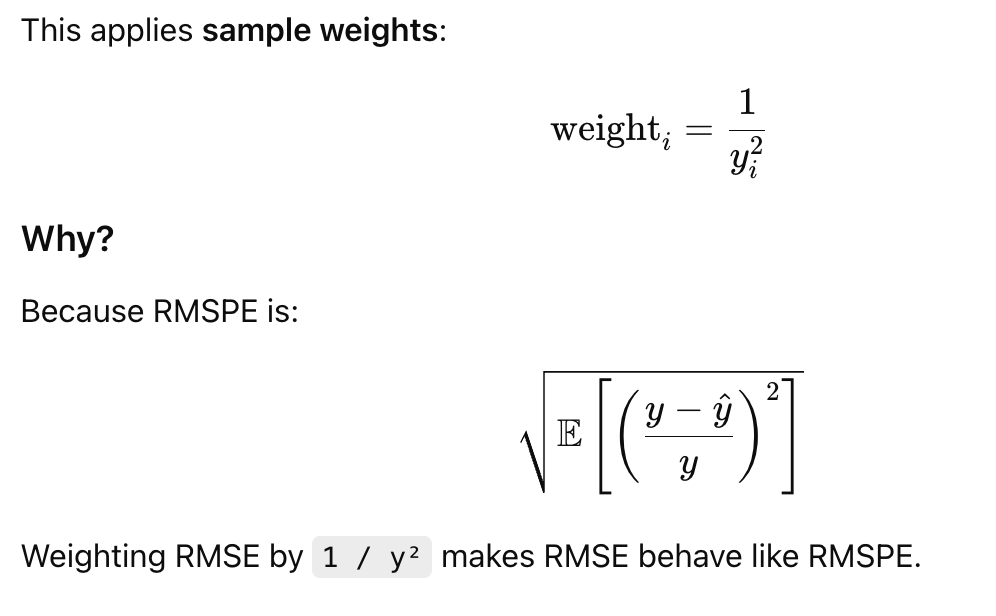

In [172]:
%%time
for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):

    print("Fold :", fold+1)
    
    # create dataset
    X_train, y_train = X.loc[trn_idx], y[trn_idx]
    X_valid, y_valid = X.loc[val_idx], y[val_idx]
    
    #RMSPE weight
    weights = 1/np.square(y_train)
    lgbm_train = lgbm.Dataset(X_train,y_train,weight = weights)

    weights = 1/np.square(y_valid)
    lgbm_valid = lgbm.Dataset(X_valid,y_valid,reference = lgbm_train,weight = weights)
    
    # model 
    eval_result = {}
    callbacks = [
        lgbm.early_stopping(stopping_rounds=100, verbose=True),
        lgbm.record_evaluation(eval_result)
    ]

    model = lgbm.train(params=params,
                      train_set=lgbm_train,
                      valid_sets=[lgbm_train, lgbm_valid], #evaluate performance on the validation set
                      valid_names=['train','valid'],
                      num_boost_round=5000,      #train up to 5000 trees   
                      feval=feval_RMSPE, #use RMSPE as the evaluation metrics
                      #categorical_feature = ['stock_id'],
                      callbacks=callbacks                
                     )
    
    # validation 
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    RMSPE = round(rmspe(y_true = y_valid, y_pred = y_pred),3)
    print(f'Performance of the　prediction: , RMSPE: {RMSPE}')

    #keep scores and models
    scores += RMSPE / 5 #because of 5-fold CV
    models.append(model)
    print("*" * 100)
    
    # --- calc model feature importance ---
    if DO_FEAT_IMP:    
        feature_names = X_train.columns.values.tolist()
        gain_importance_df = calc_model_importance(
            model, feature_names=feature_names, importance_type='gain')
        gain_importance_list.append(gain_importance_df)

        split_importance_df = calc_model_importance(
            model, feature_names=feature_names, importance_type='split')
        split_importance_list.append(split_importance_df)

Fold : 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6996
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 28
[LightGBM] [Info] Start training from score 0.001797
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1122]	train's rmse: 0.000490617	train's RMSPE: 0.22724	valid's rmse: 0.000518459	valid's RMSPE: 0.23918
Performance of the　prediction: , RMSPE: 0.239
****************************************************************************************************
Fold : 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And

#### Why are params the way they are?
Plot the model output to see if it converge

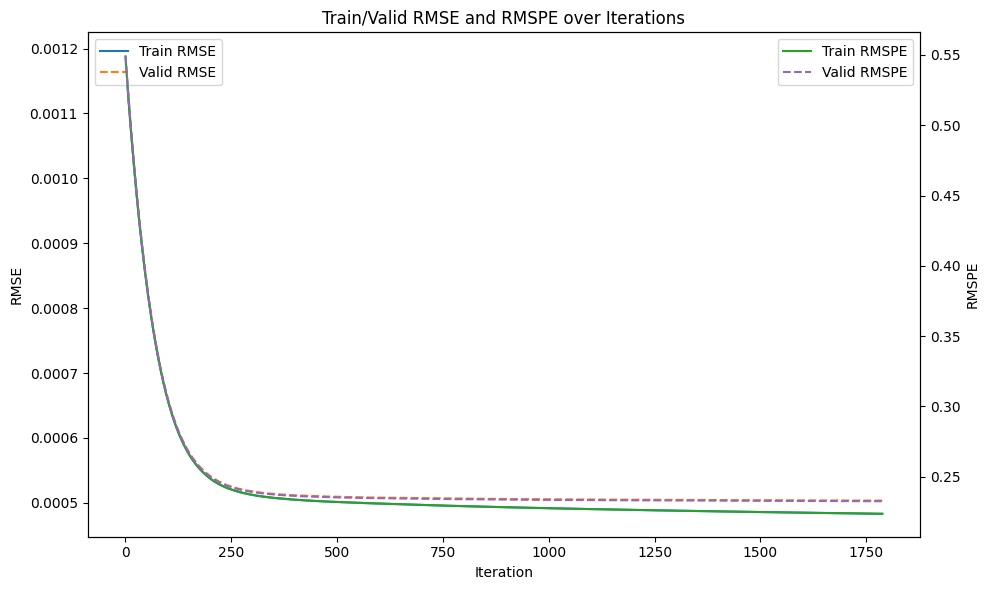

In [232]:
# plot with two y-axes: RMSE (left) and RMSPE (right)
train_rmse = eval_result['train']['rmse']
valid_rmse = eval_result['valid']['rmse']
train_rmspe = eval_result['train']['RMSPE']
valid_rmspe = eval_result['valid']['RMSPE']

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(train_rmse, label='Train RMSE', color='tab:blue')
ax1.plot(valid_rmse, label='Valid RMSE', color='tab:orange', linestyle='--')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('RMSE')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(train_rmspe, label='Train RMSPE', color='tab:green')
ax2.plot(valid_rmspe, label='Valid RMSPE', color='tab:purple', linestyle='--')
ax2.set_ylabel('RMSPE')
ax2.legend(loc='upper right')

plt.title('Train/Valid RMSE and RMSPE over Iterations')
plt.tight_layout()
plt.show()

In [143]:
scores

np.float64(0.2358)

In [144]:
def calc_mean_importance(importance_df_list):
    mean_importance = np.mean(
        np.array([df['importance'].values for df in importance_df_list]), axis=0)
    mean_df = importance_df_list[0].copy()
    mean_df['importance'] = mean_importance
    return mean_df

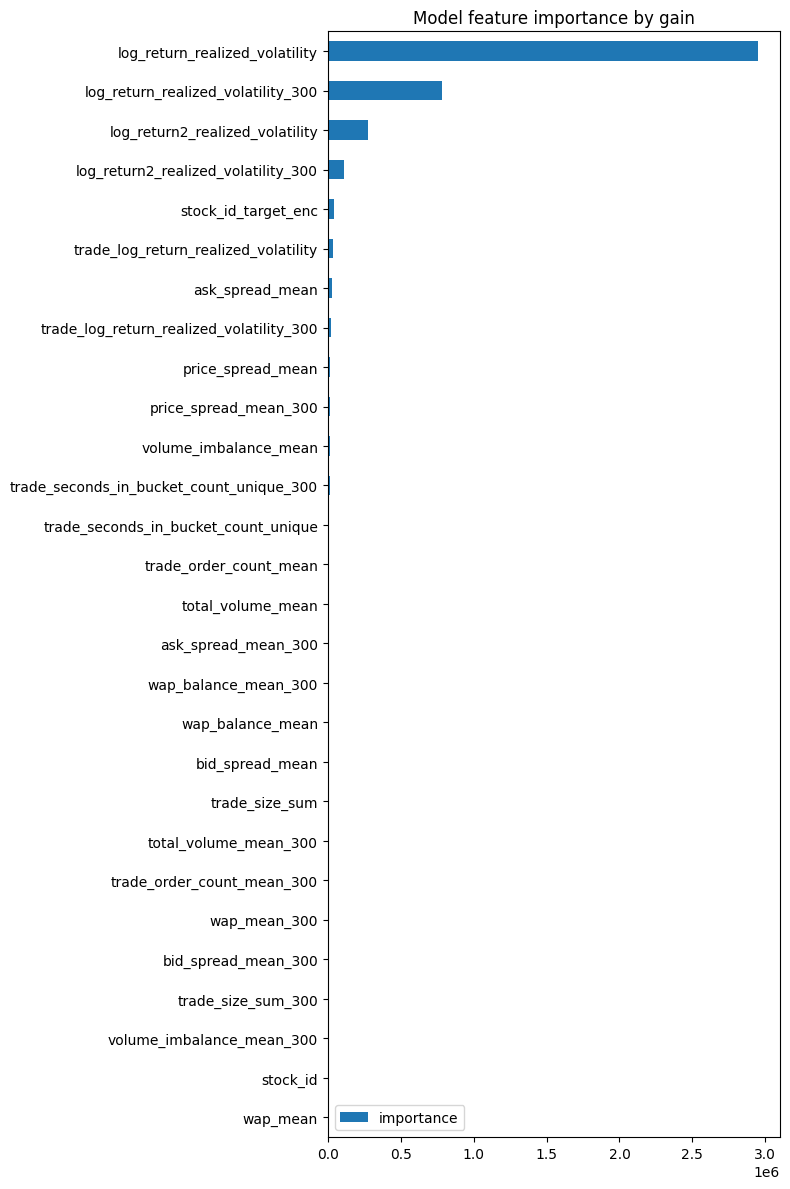

In [145]:
if DO_FEAT_IMP:
    mean_gain_df = calc_mean_importance(gain_importance_list)
    plot_importance(mean_gain_df, title='Model feature importance by gain')
    mean_gain_df = mean_gain_df.reset_index().rename(columns={'index': 'feature_names'})
    mean_gain_df.to_csv('gain_importance_mean.csv', index=False)

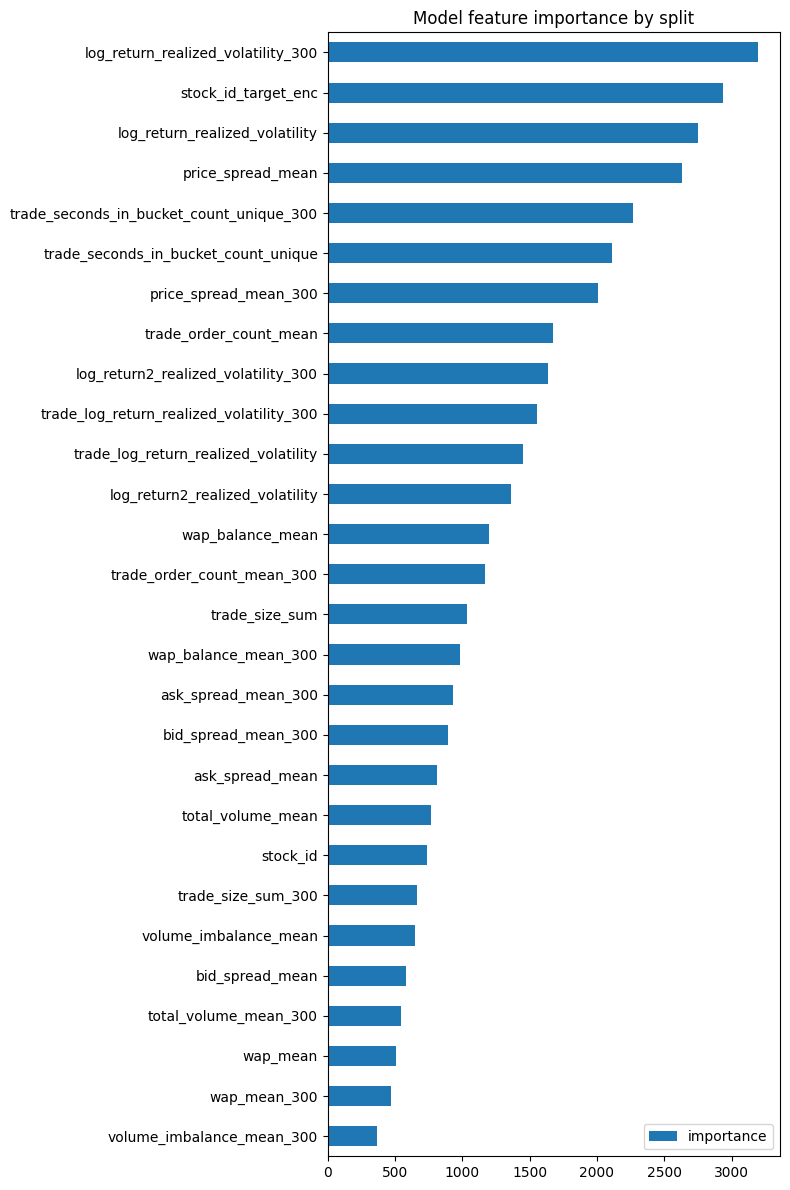

In [146]:
if DO_FEAT_IMP:
    mean_split_df = calc_mean_importance(split_importance_list)
    plot_importance(mean_split_df, title='Model feature importance by split')
    mean_split_df = mean_split_df.reset_index().rename(columns={'index': 'feature_names'})
    mean_split_df.to_csv('split_importance_mean.csv', index=False)

#### Test set

In [147]:
df_test.columns

Index(['stock_id', 'time_id', 'row_id', 'log_return_realized_volatility',
       'log_return2_realized_volatility', 'wap_balance_mean',
       'price_spread_mean', 'bid_spread_mean', 'ask_spread_mean',
       'volume_imbalance_mean', 'total_volume_mean', 'wap_mean',
       'log_return_realized_volatility_300',
       'log_return2_realized_volatility_300', 'wap_balance_mean_300',
       'price_spread_mean_300', 'bid_spread_mean_300', 'ask_spread_mean_300',
       'volume_imbalance_mean_300', 'total_volume_mean_300', 'wap_mean_300',
       'trade_log_return_realized_volatility',
       'trade_seconds_in_bucket_count_unique', 'trade_size_sum',
       'trade_order_count_mean', 'trade_log_return_realized_volatility_300',
       'trade_seconds_in_bucket_count_unique_300', 'trade_size_sum_300',
       'trade_order_count_mean_300', 'stock_id_target_enc'],
      dtype='object')

In [148]:
df_train.columns

Index(['row_id', 'target', 'log_return_realized_volatility',
       'log_return2_realized_volatility', 'wap_balance_mean',
       'price_spread_mean', 'bid_spread_mean', 'ask_spread_mean',
       'volume_imbalance_mean', 'total_volume_mean', 'wap_mean',
       'log_return_realized_volatility_300',
       'log_return2_realized_volatility_300', 'wap_balance_mean_300',
       'price_spread_mean_300', 'bid_spread_mean_300', 'ask_spread_mean_300',
       'volume_imbalance_mean_300', 'total_volume_mean_300', 'wap_mean_300',
       'trade_log_return_realized_volatility',
       'trade_seconds_in_bucket_count_unique', 'trade_size_sum',
       'trade_order_count_mean', 'trade_log_return_realized_volatility_300',
       'trade_seconds_in_bucket_count_unique_300', 'trade_size_sum_300',
       'trade_order_count_mean_300', 'stock_id', 'stock_id_target_enc'],
      dtype='object')

In [149]:
y_pred = df_test[['row_id']]
X_test = df_test.drop(['time_id', 'row_id'], axis = 1)

In [150]:
X_test

,stock_id,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,...,wap_mean_300,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,stock_id_target_enc
0,0,0.000294,0.000252,0.000145,0.000557,0.000393,-0.000115,164.666667,350.666667,1.000405,...,NaN,0.000295,3.0,201.0,3.666667,NaN,NaN,NaN,NaN,0.004028
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004028
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004028


In [151]:
target = np.zeros(len(X_test))
X['stock_id'] = X['stock_id'].astype(int)
X_test['stock_id'] = X_test['stock_id'].astype(int)

#light gbm models
for model in models:
    pred = model.predict(X_test[X_valid.columns], num_iteration=model.best_iteration)
    target += pred / len(models)

In [152]:
y_pred = y_pred.assign(target = target)

In [153]:
y_pred

,row_id,target
0,0-4,0.000930
1,0-32,0.000776
2,0-34,0.000776


In [ ]:
#y_pred.to_csv('submission.csv',index = False)

### 4.3 NN

# Model Selection

Let's explore the best solution, which is to use light gbm.

## What's changed?
FE: (by importance)
- stock_id 
- sliding window time-series feature (more than just 300)
- size_tau
- total_volume_sum
- price spread

Parameter tuning:
- same objective on rmse
- larger learning rate @ 0.05
- less lasso reg @ 0.1
- use stock_id as the categorical column

## Feature Engineering